In [1]:
def read_data(filename):
    with open(filename, 'r',  encoding="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('./data/ratings_train.txt')
test_data = read_data('./data/ratings_test.txt')

In [2]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

150000
3
50000
3


In [3]:
from konlpy.tag import Okt

okt = Okt()
print (okt.pos(u'동해물과 백두산이 마르고 닳도록 하느님이 보우하사.'))

[('동', 'Modifier'), ('해물', 'Noun'), ('과', 'Josa'), ('백두산', 'Noun'), ('이', 'Josa'), ('마르고', 'Noun'), ('닳도록', 'Verb'), ('하느님', 'Noun'), ('이', 'Josa'), ('보우', 'Noun'), ('하사', 'Noun'), ('.', 'Punctuation')]


In [4]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('./data/train_docs.json'):
    with open('./data/train_docs.json','r', encoding="utf-8") as f:
        train_docs = json.load(f)
    with open('./data/test_docs.json','r', encoding="utf-8") as f:
        test_docs = json.load(f)
else:
    
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

    with open('./data/train_docs.json','w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('./data/test_docs.json','w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [5]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [6]:
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


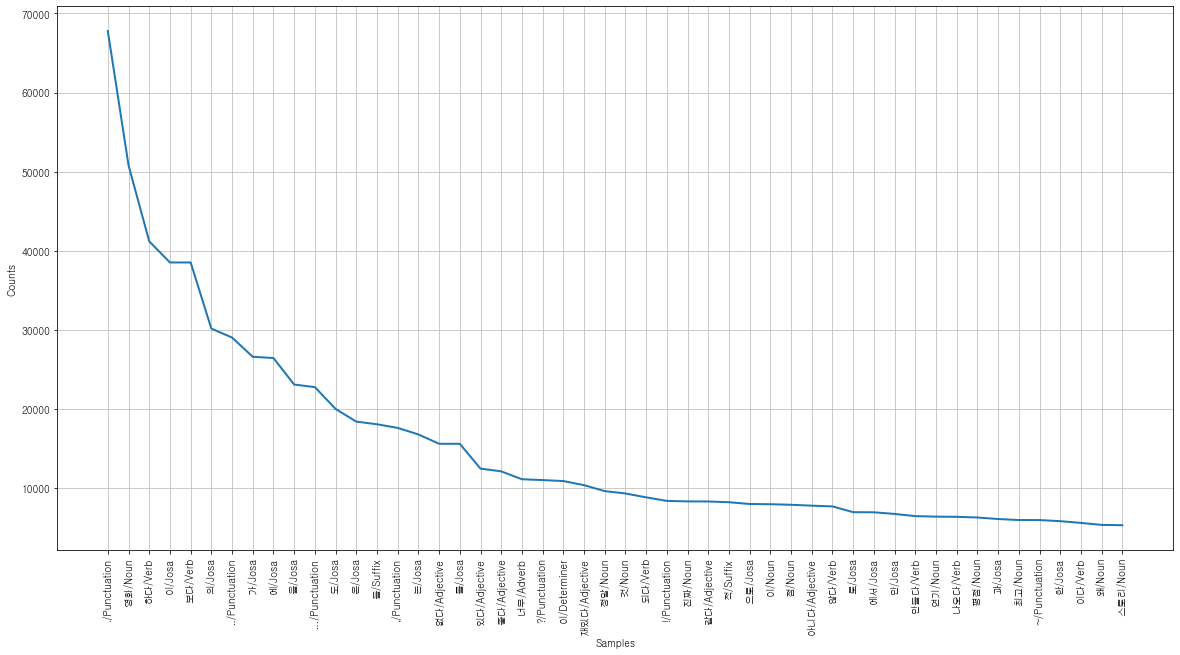

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [8]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [9]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/10
293/293 [==============================] - 6s 22ms/step - loss: 0.3893 - binary_accuracy: 0.8341
Epoch 2/10
293/293 [==============================] - 6s 21ms/step - loss: 0.3176 - binary_accuracy: 0.8650
Epoch 3/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2934 - binary_accuracy: 0.8773
Epoch 4/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2748 - binary_accuracy: 0.8880
Epoch 5/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2566 - binary_accuracy: 0.8963
Epoch 6/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2383 - binary_accuracy: 0.9056
Epoch 7/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2197 - binary_accuracy: 0.9145
Epoch 8/10
293/293 [==============================] - 6s 21ms/step - loss: 0.2015 - binary_accuracy: 0.9221
Epoch 9/10
293/293 [==============================] - 6s 21ms/step - loss: 0.1851 - binary_accuracy: 0.9288
Epoch 10/10
1563/1563 [=====

In [11]:
results

[0.4054677486419678, 0.852400004863739]

In [12]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [13]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")

[올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.]는 98.63% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.]는 98.70% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ]는 99.44% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^

[믿고 보는 감독이지만 이번에는 아니네요]는 50.46% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;

[주연배우 때문에 봤어요]는 80.23% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;



In [14]:
def make_dictionary(word):
    token = tokenize(word)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.8):
        score = score * 100
        spoint = str(score)
        strReturn = token[0] + "/" + spoint
    else:
        strReturn = "fault"

    return strReturn

# print (len(set(text.tokens))) 
checkwords = set(text.tokens)
arrcheckwords = list(checkwords)
# print ((arrcheckwords[0].split("/"))[0])
positive_dictionary = open("./data/positive_dictionary.txt","w",encoding="utf-8")
for t in arrcheckwords:
    result = make_dictionary((t.split("/"))[0])
    if result != "fault":
       positive_dictionary.write(result+"\n")
positive_dictionary.close()